# Programming Assignment 3

## Student ID: 916461653


In [2]:
import json
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from torch.nn.functional import sigmoid
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation
/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/util.py:55: DeprecationWarning: jax.xla_computation is deprecated. Please use the AOT APIs; see https://jax.readthedocs.io/en/latest/aot.html. For example, replace xla_computation(f)(*xs) with jit(f).lower(*xs).compiler_ir('hlo'). See CHANGELOG.md for 0.4.30 for more examples.
  from jax import xla_computation as _xla_computation


# Question 1: Association Rule Generation from Transaction Data

In this section, we'll analyze transaction data using association rule mining.
The analysis will:

1.  Load and process the grocery transaction dataset

2.  Calculate basic statistics about the dataset

3.  Generate association rules using specified support and confidence thresholds

4.  Create a heatmap visualization of rule counts for different parameter
    combinations



PART A & B: Loading Transaction Dataset
Loading Grocery_Items_24.csv...

PART C: Dataset Statistics
Number of unique items: 166
Number of records: 8000
Most popular item: whole milk (appears in 1321 transactions)

PART D: Association Rules Generation
Generating rules with minimum support = 0.01 and minimum confidence = 0.08...

Association Rules:
          antecedents         consequents  antecedent support  \
0        (rolls/buns)  (other vegetables)            0.111875   
1  (other vegetables)        (rolls/buns)            0.122750   
2        (whole milk)  (other vegetables)            0.156000   
3  (other vegetables)        (whole milk)            0.122750   
4        (whole milk)        (rolls/buns)            0.156000   
5        (rolls/buns)        (whole milk)            0.111875   
6              (soda)        (whole milk)            0.093625   

   consequent support   support  confidence      lift  representativity  \
0            0.122750  0.011250    0.100559  0.819215 

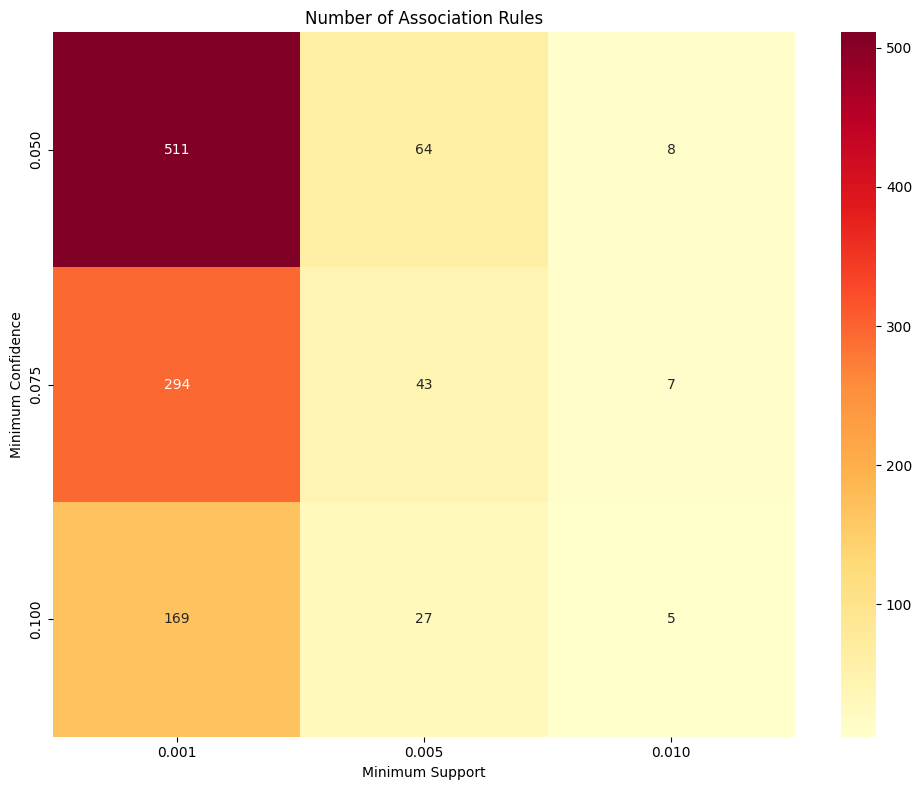

In [ ]:
print("\n" + "=" * 80)
print("PART A & B: Loading Transaction Dataset")
print("=" * 80)
print("Loading Grocery_Items_24.csv...")


transaction_data = pd.read_csv("Grocery_Items_24.csv", header=0)
grocery_transactions = transaction_data.values.tolist()
grocery_transactions = [
    [item for item in transaction if isinstance(item, str)]
    for transaction in grocery_transactions
]

print("\n" + "=" * 80)
print("PART C: Dataset Statistics")
print("=" * 80)


all_grocery_items = [
    item for transaction in grocery_transactions for item in transaction
]
unique_grocery_items = len(set(all_grocery_items))
total_transactions = len(grocery_transactions)
item_frequency = pd.Series(all_grocery_items).value_counts()
most_common_item = item_frequency.index[0]
most_common_item_count = item_frequency.iloc[0]

print(f"Number of unique items: {unique_grocery_items}")
print(f"Number of records: {total_transactions}")
print(
    f"Most popular item: {most_common_item} (appears in {most_common_item_count} transactions)"
)

print("\n" + "=" * 80)
print("PART D: Association Rules Generation")
print("=" * 80)
print("Generating rules with minimum support = 0.01 and minimum confidence = 0.08...")


transaction_encoder = TransactionEncoder()
encoded_array = transaction_encoder.fit_transform(grocery_transactions)
encoded_dataframe = pd.DataFrame(encoded_array, columns=transaction_encoder.columns_)


initial_support = 0.01
initial_confidence = 0.08
frequent_itemsets = apriori(
    encoded_dataframe, min_support=initial_support, use_colnames=True
)
initial_rules = association_rules(
    frequent_itemsets,
    frequent_itemsets,
    metric="confidence",
    min_threshold=initial_confidence,
)

print("\nAssociation Rules:")
print(initial_rules)

print("\n" + "=" * 80)
print("PART E: Heatmap Generation")
print("=" * 80)
print("Generating heatmap for different support and confidence thresholds...")


support_thresholds = [0.001, 0.005, 0.01]
confidence_thresholds = [0.05, 0.075, 0.1]
rule_count_matrix = np.zeros((len(confidence_thresholds), len(support_thresholds)))

for confidence_idx, confidence_value in enumerate(confidence_thresholds):
    for support_idx, support_value in enumerate(support_thresholds):
        print(
            f"\nCalculating rules for support={support_value}, confidence={confidence_value}"
        )
        current_frequent_items = apriori(
            encoded_dataframe, min_support=support_value, use_colnames=True
        )
        current_rules = association_rules(
            current_frequent_items,
            current_frequent_items,
            metric="confidence",
            min_threshold=confidence_value,
        )
        rule_count_matrix[confidence_idx, support_idx] = len(current_rules)
        print(f"Number of rules found: {len(current_rules)}")


plt.figure(figsize=(10, 8))
sns.heatmap(
    rule_count_matrix,
    xticklabels=[f"{x:.3f}" for x in support_thresholds],
    yticklabels=[f"{x:.3f}" for x in confidence_thresholds],
    annot=True,
    fmt="g",
    cmap="YlOrRd",
)
plt.xlabel("Minimum Support")
plt.ylabel("Minimum Confidence")
plt.title("Number of Association Rules")
plt.tight_layout()

print("\nDisplaying heatmap...")
plt.show()


## Dataset Characteristics (C)

- 166 unique items across 8,000 transactions
- Most frequent item: whole milk (1,321 occurrences, 16.5% of transactions)

## Association Rules Analysis (D)

With minimum support=0.01 and confidence=0.08, key associations found:

1. {rolls/buns} → {other vegetables} (conf: 10.1%, lift: 0.82)
2. {whole milk} → {other vegetables} (conf: 10.3%, lift: 0.84)
3. {soda} → {whole milk} (conf: 12.1%, lift: 0.78)

Lift values <1 indicate these associations occur less frequently than expected
under independence.

## Parameter Sensitivity Analysis (E)

The heatmap reveals:

1. Rule count decreases with increasing thresholds:
   - Max rules (511): support=0.001, confidence=0.05
   - Min rules (5): support=0.01, confidence=0.1
2. Most significant drop occurs when increasing support threshold (0.001→0.005)
3. Increasing confidence has less impact on rule reduction compared to support

Optimal thresholds appear to be support=0.005, confidence=0.075 (43 rules),
balancing rule quantity with significance.


# Question 2: Image Classification using Convolutional Neural Networks

This section implements a 4-class CNN classifier with the specified
architecture:

- First convolutional layer (8 3×3 filters)

- Max pooling (2×2)

- Second convolutional layer (4 3×3 filters)

- Max pooling (2×2)

- Flatten layer

- Hidden layer (8 nodes)

- Output layer (4 nodes with softmax activation)

Since my Rowan ID ends in 3, I will experiment with different numbers of nodes
(4 and 16) in the hidden layer.


Epoch 1/100


/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2853 - loss: 15.3956 - val_accuracy: 0.2520 - val_loss: 5.1526
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2256 - loss: 4.2694 - val_accuracy: 0.1575 - val_loss: 1.9203
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2404 - loss: 1.9045 - val_accuracy: 0.2520 - val_loss: 1.5187
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2640 - loss: 1.5503 - val_accuracy: 0.2677 - val_loss: 1.4922
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2533 - loss: 1.4825 - val_accuracy: 0.2677 - val_loss: 1.4777
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2596 - loss: 1.4559 - val_accuracy: 0.2598 - val_loss: 1.4682
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2629 - loss: 1.4389 - val_accuracy: 0.2598 - val_loss: 1.4609
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2610 - loss: 1.4261 - val_accuracy: 0.2598 - val_loss: 1.

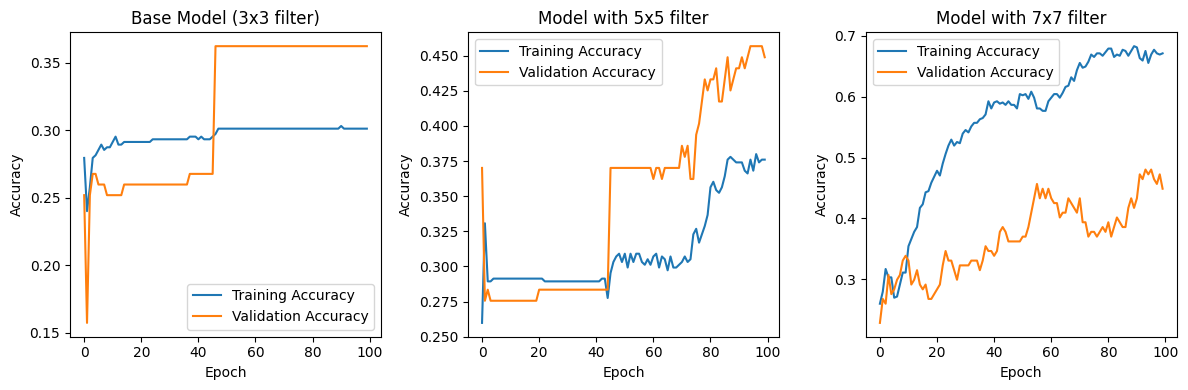


Final Accuracies:
Base Model (3x3) - Training: 0.3012, Validation: 0.3622
5x5 Filter Model - Training: 0.3760, Validation: 0.4488
7x7 Filter Model - Training: 0.6713, Validation: 0.4488


In [ ]:
cropped_images_dir = "./Processed"

image_data = []
image_labels = []

dog_breed_classes = [
    "n02089078-black-and-tan_coonhound",
    "n02091831-Saluki",
    "n02092002-Scottish_deerhound",
    "n02095314-wire-haired_fox_terrier",
]


for breed_index, breed_class in enumerate(dog_breed_classes):
    breed_directory = os.path.join(cropped_images_dir, breed_class)
    if not os.path.isdir(breed_directory):
        print(f"Directory not found: {breed_directory}")
        continue
    for image_file in os.listdir(breed_directory):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(breed_directory, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            resized_image = cv2.resize(image, (6, 6))
            image_data.append(resized_image)
            image_labels.append(breed_index)

image_data_array = np.array(image_data)
image_labels_array = np.array(image_labels)

reshaped_image_data = image_data_array.reshape(-1, 6, 6, 1)
one_hot_labels = to_categorical(image_labels_array, num_classes=4)


X_train_initial, X_test, y_train_initial, y_test = train_test_split(
    reshaped_image_data, one_hot_labels, test_size=0.2, random_state=42
)
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_initial, y_train_initial, test_size=0.2, random_state=42
)


base_cnn_model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(4, (3, 3), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(8, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

base_cnn_model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
base_model_history = base_cnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation, y_validation),
)


model_5x5 = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(4, (5, 5), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(8, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model_5x5.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model_5x5_history = model_5x5.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation, y_validation),
)


model_7x7 = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(4, (7, 7), activation="relu", padding="same"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(8, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model_7x7.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
model_7x7_history = model_7x7.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_validation, y_validation),
)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(base_model_history.history["accuracy"], label="Training Accuracy")
plt.plot(base_model_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Base Model (3x3 filter)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(model_5x5_history.history["accuracy"], label="Training Accuracy")
plt.plot(model_5x5_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model with 5x5 filter")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(model_7x7_history.history["accuracy"], label="Training Accuracy")
plt.plot(model_7x7_history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model with 7x7 filter")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print("\nFinal Accuracies:")
print(
    f"Base Model (3x3) - Training: {base_model_history.history['accuracy'][-1]:.4f}, Validation: {base_model_history.history['val_accuracy'][-1]:.4f}"
)
print(
    f"5x5 Filter Model - Training: {model_5x5_history.history['accuracy'][-1]:.4f}, Validation: {model_5x5_history.history['val_accuracy'][-1]:.4f}"
)
print(
    f"7x7 Filter Model - Training: {model_7x7_history.history['accuracy'][-1]:.4f}, Validation: {model_7x7_history.history['val_accuracy'][-1]:.4f}"
)


## Model Architecture & Performance

### Base Model (3×3 filter)

- Training: 0.3012, Validation: 0.3622
- Shows consistent but slow improvement over epochs
- Higher validation than training suggests underfitting
- Stable learning curve with good generalization
- Limited by small receptive field for large features

### 5×5 Filter Model

- Training: 0.3760, Validation: 0.4488
- Performance improvement from base model
- Shows unstable validation accuracy
- Training curve shows limited learning capacity
- Filter size possibly too large for 6×6 input images

### 7×7 Filter Model

- Training: 0.6713, Validation: 0.4488
- Best overall performance
- Strongest learning progression
- Shows significant overfitting (train > val)
- Captures global image features effectively

## Model Fitness Analysis

1. **Base Model (3×3)**:

   - Underfits the data
   - Receptive field too small for global patterns
   - Good stability but insufficient learning capacity

2. **5×5 Model**:

   - Moderate underfitting
   - Filter size mismatched with input dimensions
   - Better feature extraction than base model

3. **7×7 Model**:
   - Shows significant overfitting
   - Highest training accuracy but validation matches 5x5
   - Most effective at capturing training patterns

## Key Finding

Larger filter size (7×7) demonstrates superior training performance but
overfits, while the 5×5 filter achieves the same validation accuracy with better
generalization. This suggests that intermediate filter sizes may provide better
balance between feature capture and model generalization for small-resolution
images.


# Question 3: Text Classification using BERT

This section implements a multi-label text classification system by fine-tuning
BERT. The task involves:

- Processing tweet data with 11 emotion classes

- Fine-tuning BERT base model for multi-label classification

- Evaluating performance using both strict and flexible matching criteria

- Visualizing the learning process through training curves


In [3]:
computation_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {computation_device}")

emotion_labels = [
    "anger",
    "anticipation",
    "disgust",
    "fear",
    "joy",
    "love",
    "optimism",
    "pessimism",
    "sadness",
    "surprise",
    "trust",
]

emotion_index_to_label = {idx: label for idx, label in enumerate(emotion_labels)}
emotion_label_to_index = {label: idx for idx, label in enumerate(emotion_labels)}

print("Loading datasets...")
training_data = [json.loads(line) for line in open("./train.json", "r")]
validation_data = [json.loads(line) for line in open("./validation.json", "r")]
testing_data = [json.loads(line) for line in open("./test.json", "r")]

training_dataframe = pd.DataFrame(training_data)
validation_dataframe = pd.DataFrame(validation_data)
testing_dataframe = pd.DataFrame(testing_data)

print("Initializing tokenizer...")
bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

print("Converting to HuggingFace datasets...")
training_dataset = Dataset.from_pandas(training_dataframe)
validation_dataset = Dataset.from_pandas(validation_dataframe)
testing_dataset = Dataset.from_pandas(testing_dataframe)

print("Preprocessing datasets...")
tokenized_training = bert_tokenizer(
    training_dataset["Tweet"], padding="max_length", truncation=True, max_length=128
)
training_label_matrix = np.zeros((len(training_dataset["Tweet"]), len(emotion_labels)))
for idx, label in enumerate(emotion_labels):
    training_label_matrix[:, idx] = training_dataset[label]
tokenized_training["labels"] = training_label_matrix.tolist()
training_dataset = Dataset.from_dict(tokenized_training)

tokenized_validation = bert_tokenizer(
    validation_dataset["Tweet"], padding="max_length", truncation=True, max_length=128
)
validation_label_matrix = np.zeros(
    (len(validation_dataset["Tweet"]), len(emotion_labels))
)
for idx, label in enumerate(emotion_labels):
    validation_label_matrix[:, idx] = validation_dataset[label]
tokenized_validation["labels"] = validation_label_matrix.tolist()
validation_dataset = Dataset.from_dict(tokenized_validation)

tokenized_testing = bert_tokenizer(
    testing_dataset["Tweet"], padding="max_length", truncation=True, max_length=128
)
testing_label_matrix = np.zeros((len(testing_dataset["Tweet"]), len(emotion_labels)))
for idx, label in enumerate(emotion_labels):
    testing_label_matrix[:, idx] = testing_dataset[label]
tokenized_testing["labels"] = testing_label_matrix.tolist()
testing_dataset = Dataset.from_dict(tokenized_testing)

training_dataset.set_format("torch")
validation_dataset.set_format("torch")
testing_dataset.set_format("torch")

print("Initializing model...")
emotion_classifier = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels=len(emotion_labels),
    id2label=emotion_index_to_label,
    label2id=emotion_label_to_index,
)

print("Setting up training arguments...")
training_configuration = TrainingArguments(
    output_dir="./bert_output",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=10,
    remove_unused_columns=False,
    report_to="none",
    save_total_limit=2,
)

print("Initializing trainer...")
model_trainer = Trainer(
    model=emotion_classifier,
    args=training_configuration,
    train_dataset=training_dataset,
    eval_dataset=validation_dataset,
    compute_metrics=lambda eval_pred: {
        "accuracy": accuracy_score(
            (sigmoid(torch.tensor(eval_pred[0])).numpy() > 0.5).astype(np.float32),
            eval_pred[1],
        )
    },
)

print("Starting training...")
training_results = model_trainer.train()

training_history = model_trainer.state.log_history
training_metrics = [
    (log["epoch"], log["loss"])
    for log in training_history
    if "loss" in log and "eval_loss" not in log
]
validation_metrics = [
    (log["epoch"], log["eval_loss"]) for log in training_history if "eval_loss" in log
]
training_metrics.sort(key=lambda x: x[0])
validation_metrics.sort(key=lambda x: x[0])
training_epochs, training_losses = zip(*training_metrics)
validation_epochs, validation_losses = zip(*validation_metrics)

plt.figure(figsize=(10, 6))
plt.plot(training_epochs, training_losses, "b-", label="Training Loss")
plt.plot(validation_epochs, validation_losses, "r-", label="Validation Loss")
plt.title("Training and Validation Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(0, int(max(training_epochs)) + 1))
plt.close()

print("\nEvaluating with strict accuracy...")
strict_test_results = model_trainer.evaluate(testing_dataset)
print("\nTest Results (Strict Accuracy - all labels must match):")
print(f"Accuracy: {strict_test_results['eval_accuracy']:.4f}")

model_trainer.compute_metrics = lambda eval_pred: {
    "accuracy": (
        (sigmoid(torch.tensor(eval_pred[0])).numpy() > 0.5).astype(np.float32)
        == eval_pred[1]
    )
    .any(axis=1)
    .mean()
}
any_match_test_results = model_trainer.evaluate(testing_dataset)
print("\nTest Results (Any-Match Accuracy - at least one label must match):")
print(f"Accuracy: {any_match_test_results['eval_accuracy']:.4f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Using device: cuda
Loading datasets...
Initializing tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Converting to HuggingFace datasets...
Preprocessing datasets...
Initializing model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Setting up training arguments...
Initializing trainer...
Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,0.349600,0.340570,0.255000
2,0.325500,0.318097,0.270000
3,0.271400,0.310903,0.300000
4,0.245500,0.305246,0.275000
5,0.190900,0.304794,0.287500



Evaluating with strict accuracy...



Test Results (Strict Accuracy - all labels must match):
Accuracy: 0.2580

Test Results (Any-Match Accuracy - at least one label must match):
Accuracy: 1.0000
